## 基于 PyTorch 的单机模型在隐语联邦学习中的包装(wrap)和使用

### 引言

随着数据隐私问题和实际业务场景的需要，联邦学习作为一种特殊的深度学习形式开始兴起，它可以在保护数据隐私的同时有效地训练模型。若将大量的单机模型迁移到联邦学习框架下，可以利用分散的数据资源、保护隐私安全，并提高模型的多样性和适应性，因此需要将大量的单机模型迁移到联邦学习框架下。

隐语联邦学习模块具有优异的兼容性，因此可以直接将基于 PyTorch 的单机模型进行封装，并在 SecretFlow 中直接使用封装好的单机模型；本教程将描述在水平联邦场景中如何将基于 PyTorch 单机模型代码调整成 SecretFlow 的代码，并成功运行。

### 加载数据集

#### 数据集介绍

Flower 数据集介绍：flower 数据集是一个包含了 5 种花卉（雏菊、蒲公英、玫瑰、向日葵、郁金香）共计 4323 张彩色图片的数据集。每种花卉都有多个角度和不同光照下的图片，每张图片的分辨率为 320x240。这个数据集常用于图像分类和机器学习算法的训练与测试。数据集中每个类别的数量分别是：daisy（633），dandelion（898），rose（641），sunflower（699），tulip（852）

下载地址: http://download.tensorflow.org/example_images/flower_photos.tgz

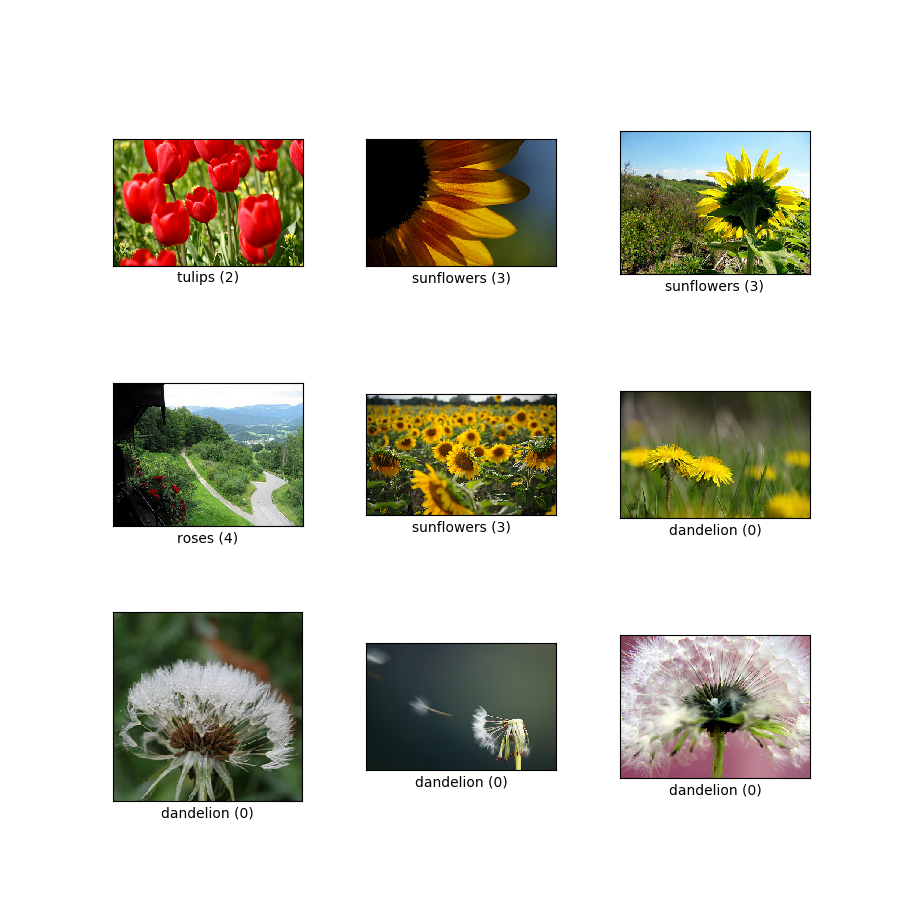

#### 下载数据集并解压

In [1]:
import os
import requests
import tarfile
import tempfile

# Create a temporary folder
_temp_dir = tempfile.mkdtemp()

# Download file
url = "https://secretflow-data.oss-accelerate.aliyuncs.com/datasets/tf_flowers/flower_photos.tgz"
save_path = os.path.join(_temp_dir, "flower_photos.tgz")

response = requests.get(url)
with open(save_path, "wb") as f:
    f.write(response.content)

# Extract the file
extract_folder = os.path.join(_temp_dir, "flower_photos")
os.makedirs(extract_folder, exist_ok=True)

with tarfile.open(save_path, "r:gz") as tar:
    tar.extractall(path=extract_folder)

path_to_flower_dataset = extract_folder


### 基于PyTorch的单机模型

#### 构建一个 PyTorch 中 Dataloader 对象

在单机模型中需要将数据集从文件夹加载成 torch 中的 Dataloader 

In [2]:
import math

import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

# parameter
batch_size = 32
shuffle = True
random_seed = 1234
train_split = 0.8

# Define dataset
flower_transform = transforms.Compose(
    [
        transforms.Resize((180, 180)),
        transforms.ToTensor(),
    ]
)
flower_dataset = datasets.ImageFolder(
    path_to_flower_dataset, transform=flower_transform
)
dataset_size = len(flower_dataset)
# Define sampler

indices = list(range(dataset_size))
if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
split = int(np.floor(train_split * dataset_size))
train_indices, val_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Define databuilder
train_loader = DataLoader(flower_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(flower_dataset, batch_size=batch_size, sampler=valid_sampler)

In [3]:
x, y = next(iter(train_loader))
print(f"x.shape = {x.shape}")
print(f"y.shape = {y.shape}")

x.shape = torch.Size([32, 3, 180, 180])
y.shape = torch.Size([32])


#### 基于 PyTorch 定义单机模型

- 定义模型的架构

In [4]:
import torch
from torch import nn

class ConvRGBNet_torch(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.network = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 45 * 45, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
        )

    def forward(self, xb):
        return self.network(xb)

- 定义损失函数和优化器

In [5]:
# initialize
model_torch = ConvRGBNet_torch()

# Define the loss function
loss_model_torch = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_model_torch = torch.optim.SGD(params=model_torch.parameters(), lr=0.01)
optimizer_model_torch.zero_grad()

#### 训练模型

In [6]:
num_epochs = 5
batch_num = len(train_loader)

model_torch.train() # prep model for training

for epoch in range(num_epochs):
    train_loss = 0.0
    
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        optimizer_model_torch.zero_grad()

        outputs = model_torch(inputs)
        loss = loss_model_torch(outputs, labels)
        loss.backward()
        optimizer_model_torch.step()

        train_loss += loss.item()
        if(batch_idx+1)%batch_num == 0: 
            print(f"Epoch {epoch+1}, Iteration {batch_idx+1}, Loss: {train_loss/batch_num}")
            #train_loss = 0.0

print("Finished Training")

Epoch 1, Iteration 30, Loss: 0.2258207323572909
Epoch 2, Iteration 30, Loss: 0.004316971625667065
Epoch 3, Iteration 30, Loss: 0.0022294739697827025
Epoch 4, Iteration 30, Loss: 0.0014839221383833015
Epoch 5, Iteration 30, Loss: 0.0011037750373361632
Finished Training


#### 测试模型

In [7]:
# valid_loader is the data loader for the test dataset, and model_torch is the trained model
model_torch.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, labels in valid_loader:
        outputs = model_torch(images)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 1.0


### 联邦学习下单机模型的包装(wrap)和使用

#### 环境设置

In [8]:
%load_ext autoreload
%autoreload 2

首先初始化各个参与方

In [9]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()
sf.init(['alice', 'bob', 'charlie'], address="local", log_to_driver=False)
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.3.0.dev20231123


2023-11-29 10:21:27,949	INFO worker.py:1538 -- Started a local Ray instance.


#### 将单机模型下的 Dataloader 包装（wrap）为 DataBuilder

将单机模型代码进行包装，便于在隐语联邦学习中使用

参考在[SecretFlow 中使用自定义 DataBuilder (Torch)构建 dataset builder](https://www.secretflow.org.cn/docs/secretflow/latest/zh-Hans/tutorial/CustomDataLoaderTorch)，我们选择文件夹路径作为参数，并且封装单机模式下的数据处理逻辑，最后返回 (data_set，steps_per_epoch)的结果

In [10]:
def create_dataset_builder(
    batch_size=32,
    train_split=0.8,
    shuffle=True,
    random_seed=1234,
):
    def dataset_builder(x, stage="train"):
        """ """
        import math

        import numpy as np
        from torch.utils.data import DataLoader
        from torch.utils.data.sampler import SubsetRandomSampler
        from torchvision import datasets, transforms

        # Define dataset
        flower_transform = transforms.Compose(
            [
                transforms.Resize((180, 180)),
                transforms.ToTensor(),
            ]
        )
        flower_dataset = datasets.ImageFolder(x, transform=flower_transform)
        dataset_size = len(flower_dataset)
        # Define sampler

        indices = list(range(dataset_size))
        if shuffle:
            np.random.seed(random_seed)
            np.random.shuffle(indices)
        split = int(np.floor(train_split * dataset_size))
        train_indices, val_indices = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        # Define databuilder
        train_loader = DataLoader(
            flower_dataset, batch_size=batch_size, sampler=train_sampler
        )
        valid_loader = DataLoader(
            flower_dataset, batch_size=batch_size, sampler=valid_sampler
        )

        # Return
        if stage == "train":
            train_step_per_epoch = len(train_loader)

            return train_loader, train_step_per_epoch
        elif stage == "eval":
            eval_step_per_epoch = len(valid_loader)
            return valid_loader, eval_step_per_epoch

    return dataset_builder

#### 构建 dataset_builder_dict

In [11]:
# prepare dataset dict
data_builder_dict = {
    alice: create_dataset_builder(
        batch_size=32,
        train_split=0.8,
        shuffle=False,
        random_seed=1234,
    ),
    bob: create_dataset_builder(
        batch_size=32,
        train_split=0.8,
        shuffle=False,
        random_seed=1234,
    ),
}

#### 定义模型架构

参考单机模式下的模型，我们在隐语的框架下定义模型。可以看到，只需修改继承类将torch.nn.Module改为secretflow.ml.nn.fl.utils.BaseModule即可。整体迁移过程非常方便，充分展现了隐语框架的易用性。

In [12]:
from secretflow.ml.nn.utils import BaseModule


class ConvRGBNet(BaseModule):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.network = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 45 * 45, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
        )

    def forward(self, xb):
        return self.network(xb)

2023-11-29 10:21:30.615512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/envs/limingbo_sf/lib/:/opt/anaconda3/envs/limingbo_sf/lib/python3.8/site-packages/nvidia/cudnn/lib
2023-11-29 10:21:30.615603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/envs/limingbo_sf/lib/:/opt/anaconda3/envs/limingbo_sf/lib/python3.8/site-packages/nvidia/cudnn/lib
2023-11-29 10:21:30.615611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned abo

In [13]:
from secretflow.ml.nn import FLModel
from secretflow.security.aggregation import SecureAggregator
from torch import nn, optim
from torchmetrics import Accuracy, Precision
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn.utils import TorchModel

参考单机模式下的损失函数和优化器，同样的，我们在隐语的框架里指定对应的损失函数和包装优化器即可，使用便捷。

In [14]:
device_list = [alice, bob]
aggregator = SecureAggregator(charlie, [alice, bob])
# prepare model
num_classes = 5

input_shape = (180, 180, 3)
# torch model
loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-3)
model_def = TorchModel(
    model_fn=ConvRGBNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(
            Accuracy, task="multiclass", num_classes=num_classes, average='micro'
        ),
        metric_wrapper(
            Precision, task="multiclass", num_classes=num_classes, average='micro'
        ),
    ],
)

fed_model = FLModel(
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    backend="torch",
    strategy="fed_avg_w",
    random_seed=1234,
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


#### 训练和验证模型

传入参与方的数据集路径，进行模型的训练和验证

In [15]:
data = {
    alice: path_to_flower_dataset,
    bob: path_to_flower_dataset,
}
history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=5,
    batch_size=32,
    aggregate_freq=2,
    sampler_method="batch",
    random_seed=1234,
    dp_spent_step_freq=1,
    dataset_builder=data_builder_dict,
)

INFO:root:FL Train Params: {'x': {PYURuntime(alice): '/tmp/tmpknkiwdvz/flower_photos', PYURuntime(bob): '/tmp/tmpknkiwdvz/flower_photos'}, 'y': None, 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': {PYURuntime(alice): '/tmp/tmpknkiwdvz/flower_photos', PYURuntime(bob): '/tmp/tmpknkiwdvz/flower_photos'}, 'shuffle': False, 'class_weight': None, 'sample_weight': None, 'validation_freq': 1, 'aggregate_freq': 2, 'label_decoder': None, 'max_batch_size': 20000, 'prefetch_buffer_size': None, 'sampler_method': 'batch', 'random_seed': 1234, 'dp_spent_step_freq': 1, 'audit_log_dir': None, 'dataset_builder': {PYURuntime(alice): <function create_dataset_builder.<locals>.dataset_builder at 0x7fcaac4f79d0>, PYURuntime(bob): <function create_dataset_builder.<locals>.dataset_builder at 0x7fc9004bb0d0>}, 'wait_steps': 100, 'self': <secretflow.ml.nn.fl.fl_model.FLModel object at 0x7fc8f8174700>}
Train Processing: :   0%|          | 0/30 [00:0

Epoch 1/5


Train Processing: :   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/5


Train Processing: :   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/5


Train Processing: :   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/5


Train Processing: :   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/5


Train Processing: :  93%|█████████▎| 28/30 [00:45<00:03,  1.64s/it, {'multiclassaccuracy': 1.0, 'multiclassprecision': 1.0, 'val_multiclassaccuracy': 1.0, 'val_multiclassprecision': 1.0}]
